---
# Epochs with different stimulus durations

In [1]:
from linescanning import (
    utils,
    plotting,
    fitting,
    preproc,
)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
import holeresponse as hr
opj = os.path.join

In [2]:
# import subject dictionary containing useful information
subj_obj = hr.utils.SubjectsDict()
subj_obj.get_colors()

['#1B9E77', '#D95F02', '#4c75ff']

In [3]:
# get h5-file
deriv = "/data1/projects/MicroFunc/Jurjen/projects/VE-SRF/derivatives"
repo_dir = "/data1/projects/MicroFunc/Jurjen/programs/project_repos/holeresponse"

incl_subjs = subj_obj.get_subjects()
h5 = utils.FindFiles(opj(deriv, "lsprep", "sub-005"), extension="h5").files
h5_files = utils.get_file_from_substring(["sub-005"], h5)
h5_files

['/data1/projects/MicroFunc/Jurjen/projects/VE-SRF/derivatives/lsprep/sub-005/sub-005_ses-2_desc-preproc_bold.h5',
 '/data1/projects/MicroFunc/Jurjen/projects/VE-SRF/derivatives/lsprep/sub-005/sub-005_ses-3_desc-preproc_bold.h5']

In [4]:
# parse h5-files
objs = {}
for task,h5,excl in zip(
    ["orig","long"], 
    h5_files,
    [True,False]):
    
    objs[task] = {}
    h5_obj = hr.data.H5Parser(
        h5,
        verbose=True,
        compartments=20,
        excl_runs=excl
    )
    objs[task]["obj"] = h5_obj

    # avg epoch
    print("Epoching average")
    sub_ep = fitting.Epoch(
        h5_obj.df_avg,
        h5_obj.df_onsets,
        TR=0.105,
        interval=[-2,14]
    )
    objs[task]["avg_epoch"] = sub_ep

    # ribbon epoch
    print("Epoching ribbon")
    comp_ep = fitting.Epoch(
        h5_obj.df_comps,
        h5_obj.df_onsets,
        TR=0.105,
        interval=[-2,14]
    )
    objs[task]["ribbon_epoch"] = sub_ep

DATASET
Reading from /data1/projects/MicroFunc/Jurjen/projects/VE-SRF/derivatives/lsprep/sub-005/sub-005_ses-2_desc-preproc_bold.h5
 Set attribute: df_blinks
 Set attribute: df_func_ica
 Set attribute: df_func_psc
 Set attribute: df_func_raw
 Set attribute: df_onsets
 Set attribute: df_responses
 Could not set attribute 'df_saccades'
 Set attribute: df_space_eye
 Set attribute: df_space_func

DATASET: created
Fetching dataframe from attribute 'df_func_psc'
Making 20 compartments
Done with 'sub-005'

Epoching average
Epoching ribbon
DATASET
Reading from /data1/projects/MicroFunc/Jurjen/projects/VE-SRF/derivatives/lsprep/sub-005/sub-005_ses-3_desc-preproc_bold.h5
 Set attribute: df_blinks
 Set attribute: df_func_ica
 Set attribute: df_func_psc
 Set attribute: df_func_raw
 Set attribute: df_onsets
 Set attribute: df_responses
 Could not set attribute 'df_saccades'
 Set attribute: df_space_eye
 Set attribute: df_space_func

DATASET: created
Fetching dataframe from attribute 'df_func_psc'
M

In [5]:
list(objs.keys())

['orig', 'long']

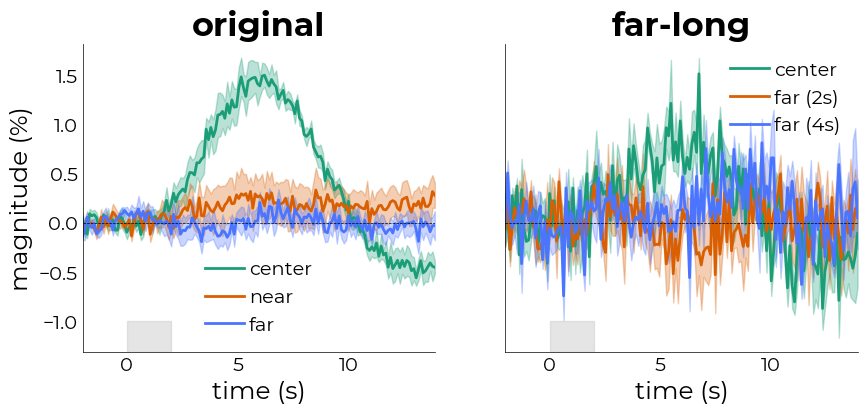

In [9]:
%matplotlib inline
fig,axs = plt.subplots(ncols=2, figsize=(10,4), sharey=True)

for ix,(key,title,evs) in enumerate(zip(
    list(objs.keys()),
    ["original","far-long"],
    [["center","near","far"],["center","far (2s)","far (4s)"]])):
    
    if ix == 0:
        y_lbl = "magnitude (%)"
    else:
        y_lbl = None
        
    select_ses = objs[key]["avg_epoch"].df_epoch
    avg_epoch = hr.viz.PlotEpochProfiles(
        select_ses.groupby(["event_type","epoch","t"]).mean(),
        axs=axs[ix],
        ev_names=evs,
        cm=subj_obj.get_colors(),
        y_label=y_lbl
    )

    axs[ix].set_title(title, fontsize=24, fontweight="bold")

In [10]:
objs["orig"]["obj"].h5_objs["sub-005"].fetch_blinks()

onset
subject task run event_type         
005     SRFa 2   blink         7.936
                 blink        15.585
                 blink        27.671
                 blink        46.287
                 blink        54.143
...                              ...
        SRFb 7   blink       326.686
                 blink       338.677
                 blink       358.424
                 blink       374.372
                 blink       376.698

[483 rows x 1 columns]

In [35]:
use_obj = "long"
func = utils.multiselect_from_df(
    objs[use_obj]["obj"].dict_ribbon["sub-005"],
    expression=[
        "subject = 005",
        "task = SRFa",
        "run = 4"
    ]
)

eye = utils.multiselect_from_df(
    objs[use_obj]["obj"].h5_objs["sub-005"].fetch_blinks(),
    expression=[
        "subject = 005",
        "task = SRFa",
        "run = 4"
    ]
)

# fit FIR model
eye_fir = fitting.NideconvFitter(
    func,
    onsets=eye,
    TR=0.105,
    verbose=True,
    basis_sets="fir",
    n_regressors="tr",
    conf_intercept=False
)
eye_fir.timecourses_condition()

Selected 'fir'-basis sets (with 190 regressors)
Adding event 'blink' to model
Fitting with 'ols' minimization
Done


In [39]:
eye_fir.tc_condition

vox 363   vox 364   vox 365   vox 366  \
event_type covariate time                                               
blink      intercept 0.00000  -0.031359 -0.242200  0.074111 -0.208037   
                     0.00525  -0.031359 -0.242200  0.074111 -0.208037   
                     0.01050  -0.031359 -0.242200  0.074111 -0.208037   
                     0.01575  -0.031359 -0.242200  0.074111 -0.208037   
                     0.02100  -0.031359 -0.242200  0.074111 -0.208037   
...                                 ...       ...       ...       ...   
                     19.92375 -0.235544 -0.192982 -0.203413 -0.238884   
                     19.92900 -0.235544 -0.192982 -0.203413 -0.238884   
                     19.93425 -0.235544 -0.192982 -0.203413 -0.238884   
                     19.93950 -0.235544 -0.192982 -0.203413 -0.238884   
                     19.94475 -0.235544 -0.192982 -0.203413 -0.238884   

                                vox 367   vox 368   vox 369   vox 370  
event_type covariate time                                              
blink      intercept 0.00000  -0.212133 -0.359055 -0.050940 -0.450964  
                     0.00525  -0.212133 -0.359055 -0.050940 -0.450964  
                     0.01050  -0.212133 -0.359055 -0.050940 -0.450964  
                     0.01575  -0.212133 -0.359055 -0.050940 -0.450964  
                     0.02100  -0.212133 -0.359055 -0.050940 -0.450964  
...                                 ...       ...       ...       ...  
                     19.92375 -0.151375 -0.250263 -0.144602 -0.201427  
                     19.92900 -0.151375 -0.250263 -0.144602 -0.201427  
                     19.93425 -0.151375 -0.250263 -0.144602 -0.201427  
                     19.93950 -0.151375 -0.250263 -0.144602 -0.201427  
                     19.94475 -0.151375 -0.250263 -0.144602 -0.201427  

[3800 rows x 8 columns]

In [55]:
use_obj = "long"
func = objs[use_obj]["obj"].dict_ribbon["sub-005"]
onsets = objs[use_obj]["obj"].h5_objs["sub-005"].df_onsets
regr_obj = preproc.EventRegression(
    func,
    onsets,
    ses=3,
    evs=["blink","response"],
    TR=0.105,
    # verbose=True,
    basis_sets="fir",
    n_regressors="tr",
    conf_intercept=False,
    make_figure=True,
    plot_kw={
        "save": True,
        "fig_dir": opj(os.path.dirname(h5_files[0]), "figures"),
        "avg": False,
    }
)

df_regr = regr_obj.df_regress.copy()

sub_id: 005
 event: blink
  task_id: SRFa
  run_ids: ['1', '2', '3', '4']
  task_id: SRFb
  run_ids: ['1', '2', '3', '4']
 event: response
  task_id: SRFa
  run_ids: ['1', '2', '3', '4']
 Writing /data1/projects/MicroFunc/Jurjen/projects/VE-SRF/derivatives/lsprep/sub-005/figures/sub-005_ses-3_task-SRFa_run-1_desc-regression.svg
 Writing /data1/projects/MicroFunc/Jurjen/projects/VE-SRF/derivatives/lsprep/sub-005/figures/sub-005_ses-3_task-SRFa_run-1_desc-modelfit.svg
 Writing /data1/projects/MicroFunc/Jurjen/projects/VE-SRF/derivatives/lsprep/sub-005/figures/sub-005_ses-3_task-SRFa_run-2_desc-regression.svg
 Writing /data1/projects/MicroFunc/Jurjen/projects/VE-SRF/derivatives/lsprep/sub-005/figures/sub-005_ses-3_task-SRFa_run-2_desc-modelfit.svg
 Writing /data1/projects/MicroFunc/Jurjen/projects/VE-SRF/derivatives/lsprep/sub-005/figures/sub-005_ses-3_task-SRFa_run-3_desc-regression.svg
 Writing /data1/projects/MicroFunc/Jurjen/projects/VE-SRF/derivatives/lsprep/sub-005/figures/sub-005_s

In [13]:
select = [
    "subject = 005",
    "task = SRFa",
    "run = 1"
]

f1 = utils.multiselect_from_df(
    func,
    expression=select
)

r1 = utils.multiselect_from_df(
    df_regr,
    expression=select
)
r1.head()

vox 363   vox 364   vox 365   vox 366   vox 367  \
subject task run t                                                         
005     SRFa 1   0.000  0.861031  0.649591  0.733441  0.718665  0.117686   
                 0.105  2.645365  2.259995  1.937151 -0.130437 -2.279222   
                 0.210  5.368024  3.703637  2.912016 -5.172840 -2.044144   
                 0.315 -8.235715 -4.124926 -2.050771  5.831050  3.065743   
                 0.420 -1.045486  0.909954  0.586812 -4.651460 -1.128029   

                          vox 368   vox 369   vox 370  
subject task run t                                     
005     SRFa 1   0.000   0.127287  0.160359 -0.346414  
                 0.105  -0.322274 -1.711810 -4.314890  
                 0.210  -7.368861  2.174913  3.277962  
                 0.315  10.400771  5.498096 -1.379708  
                 0.420  -3.883421  1.048656  3.167680

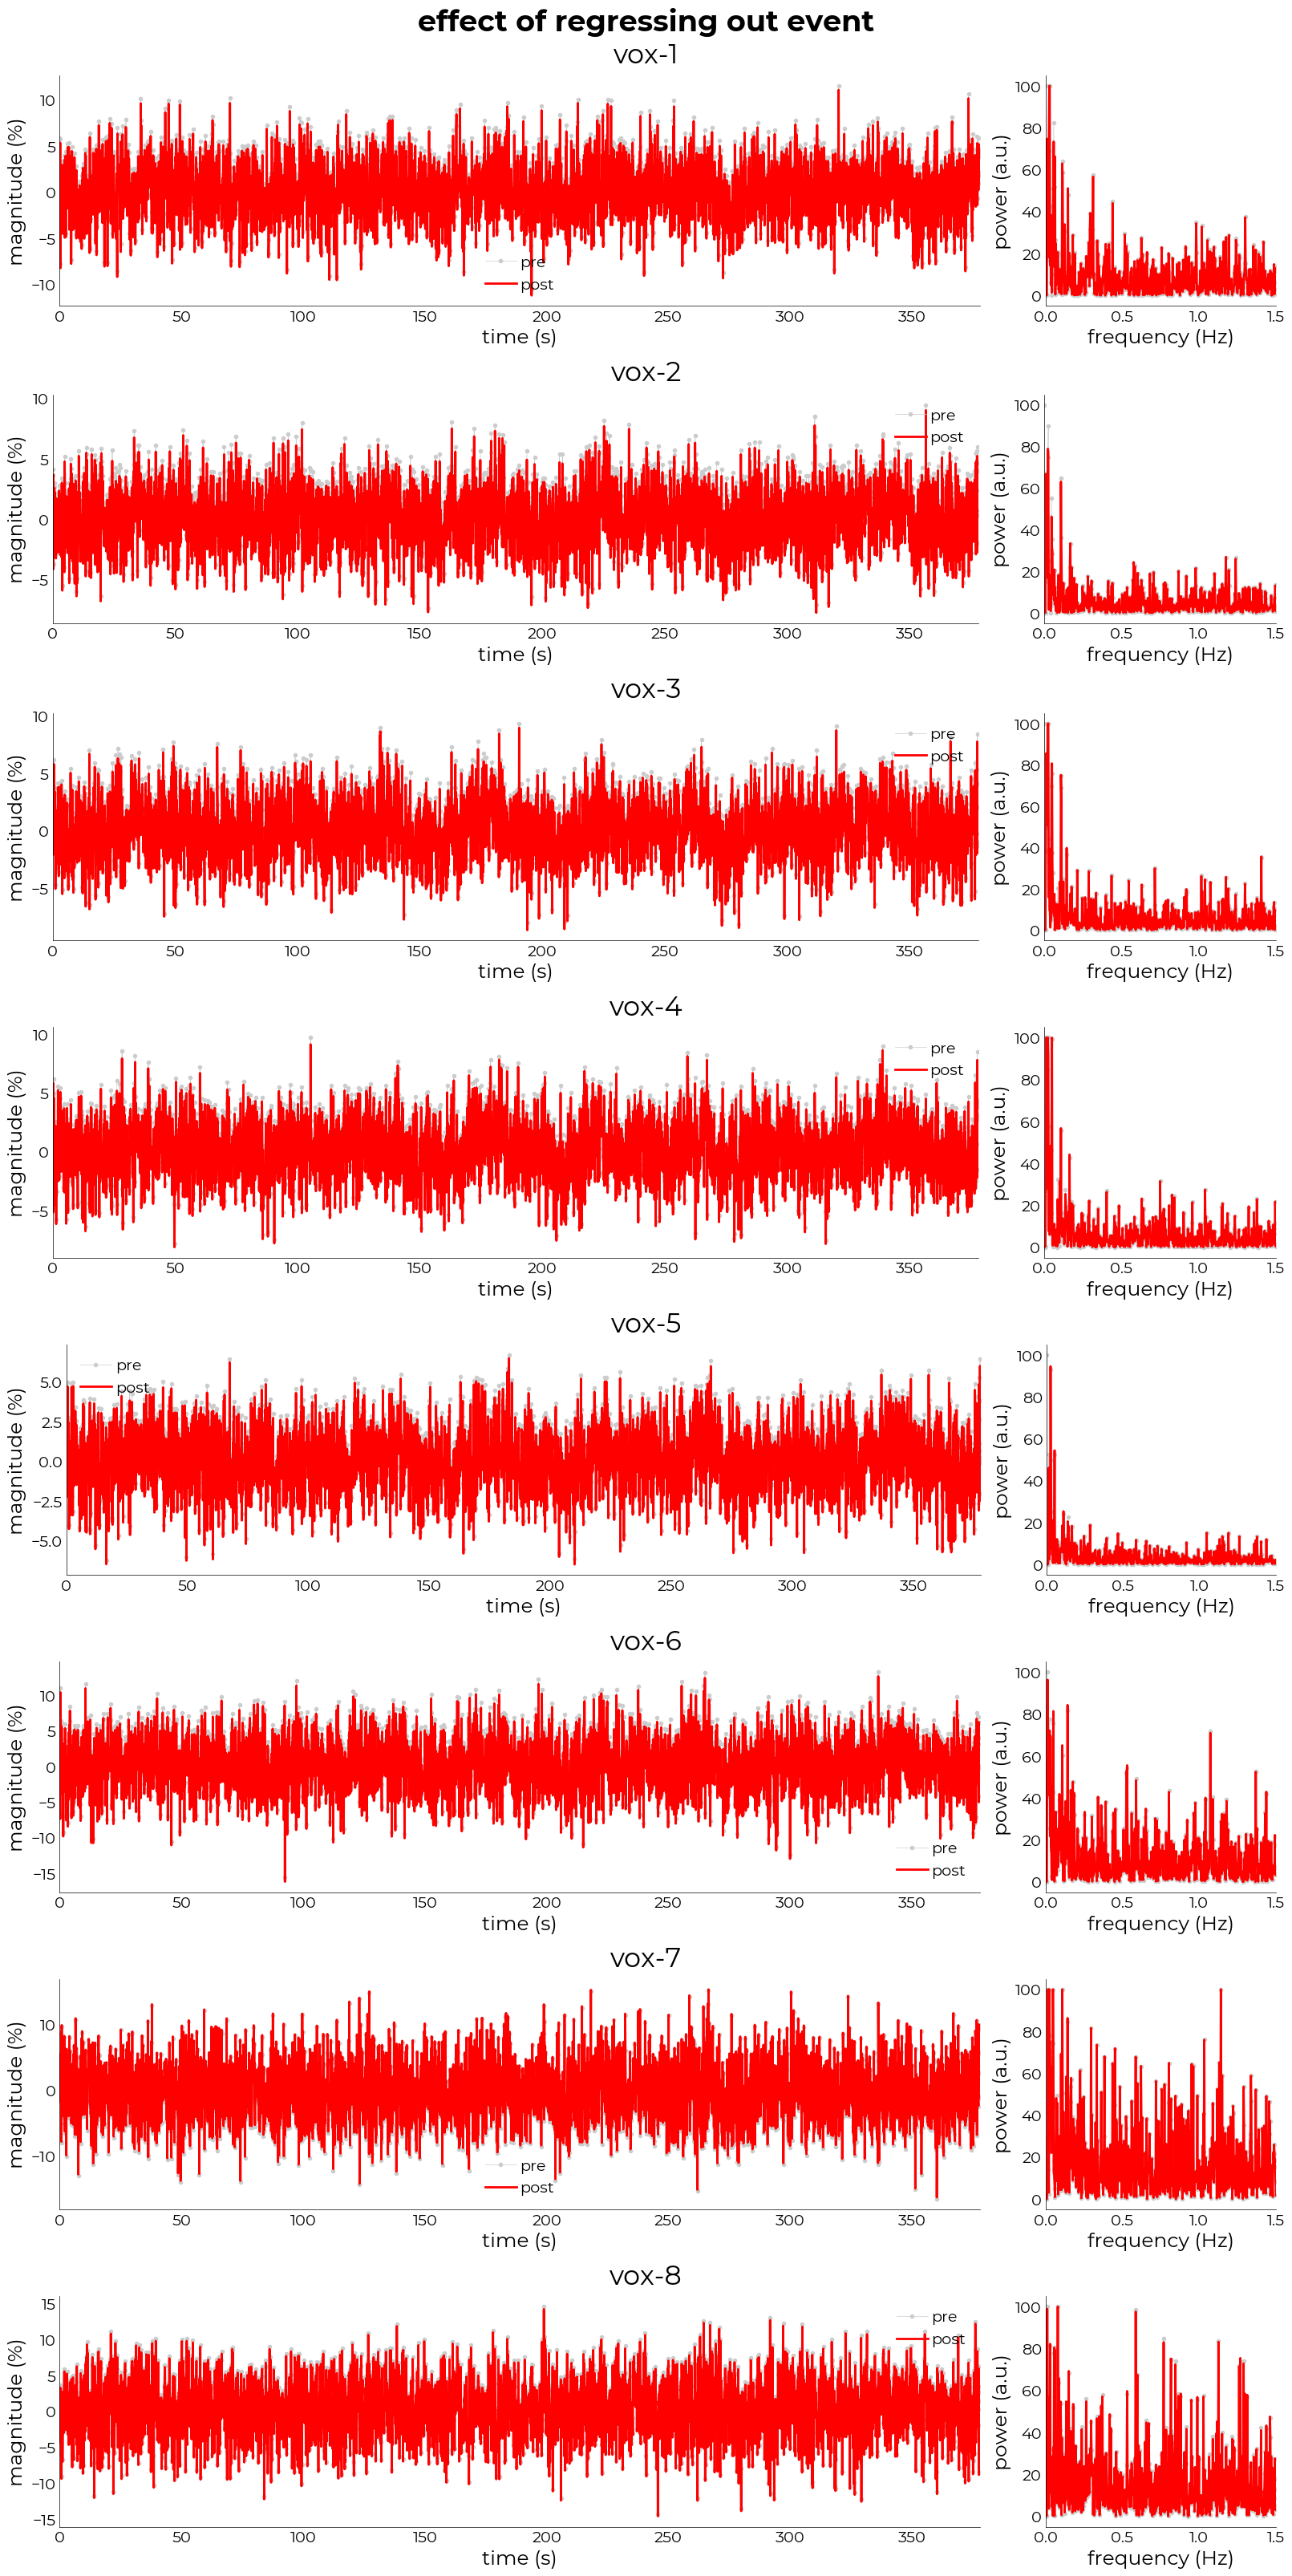

In [52]:
preproc.EventRegression.plot_result(
    f1,
    r1,
    avg=False
)

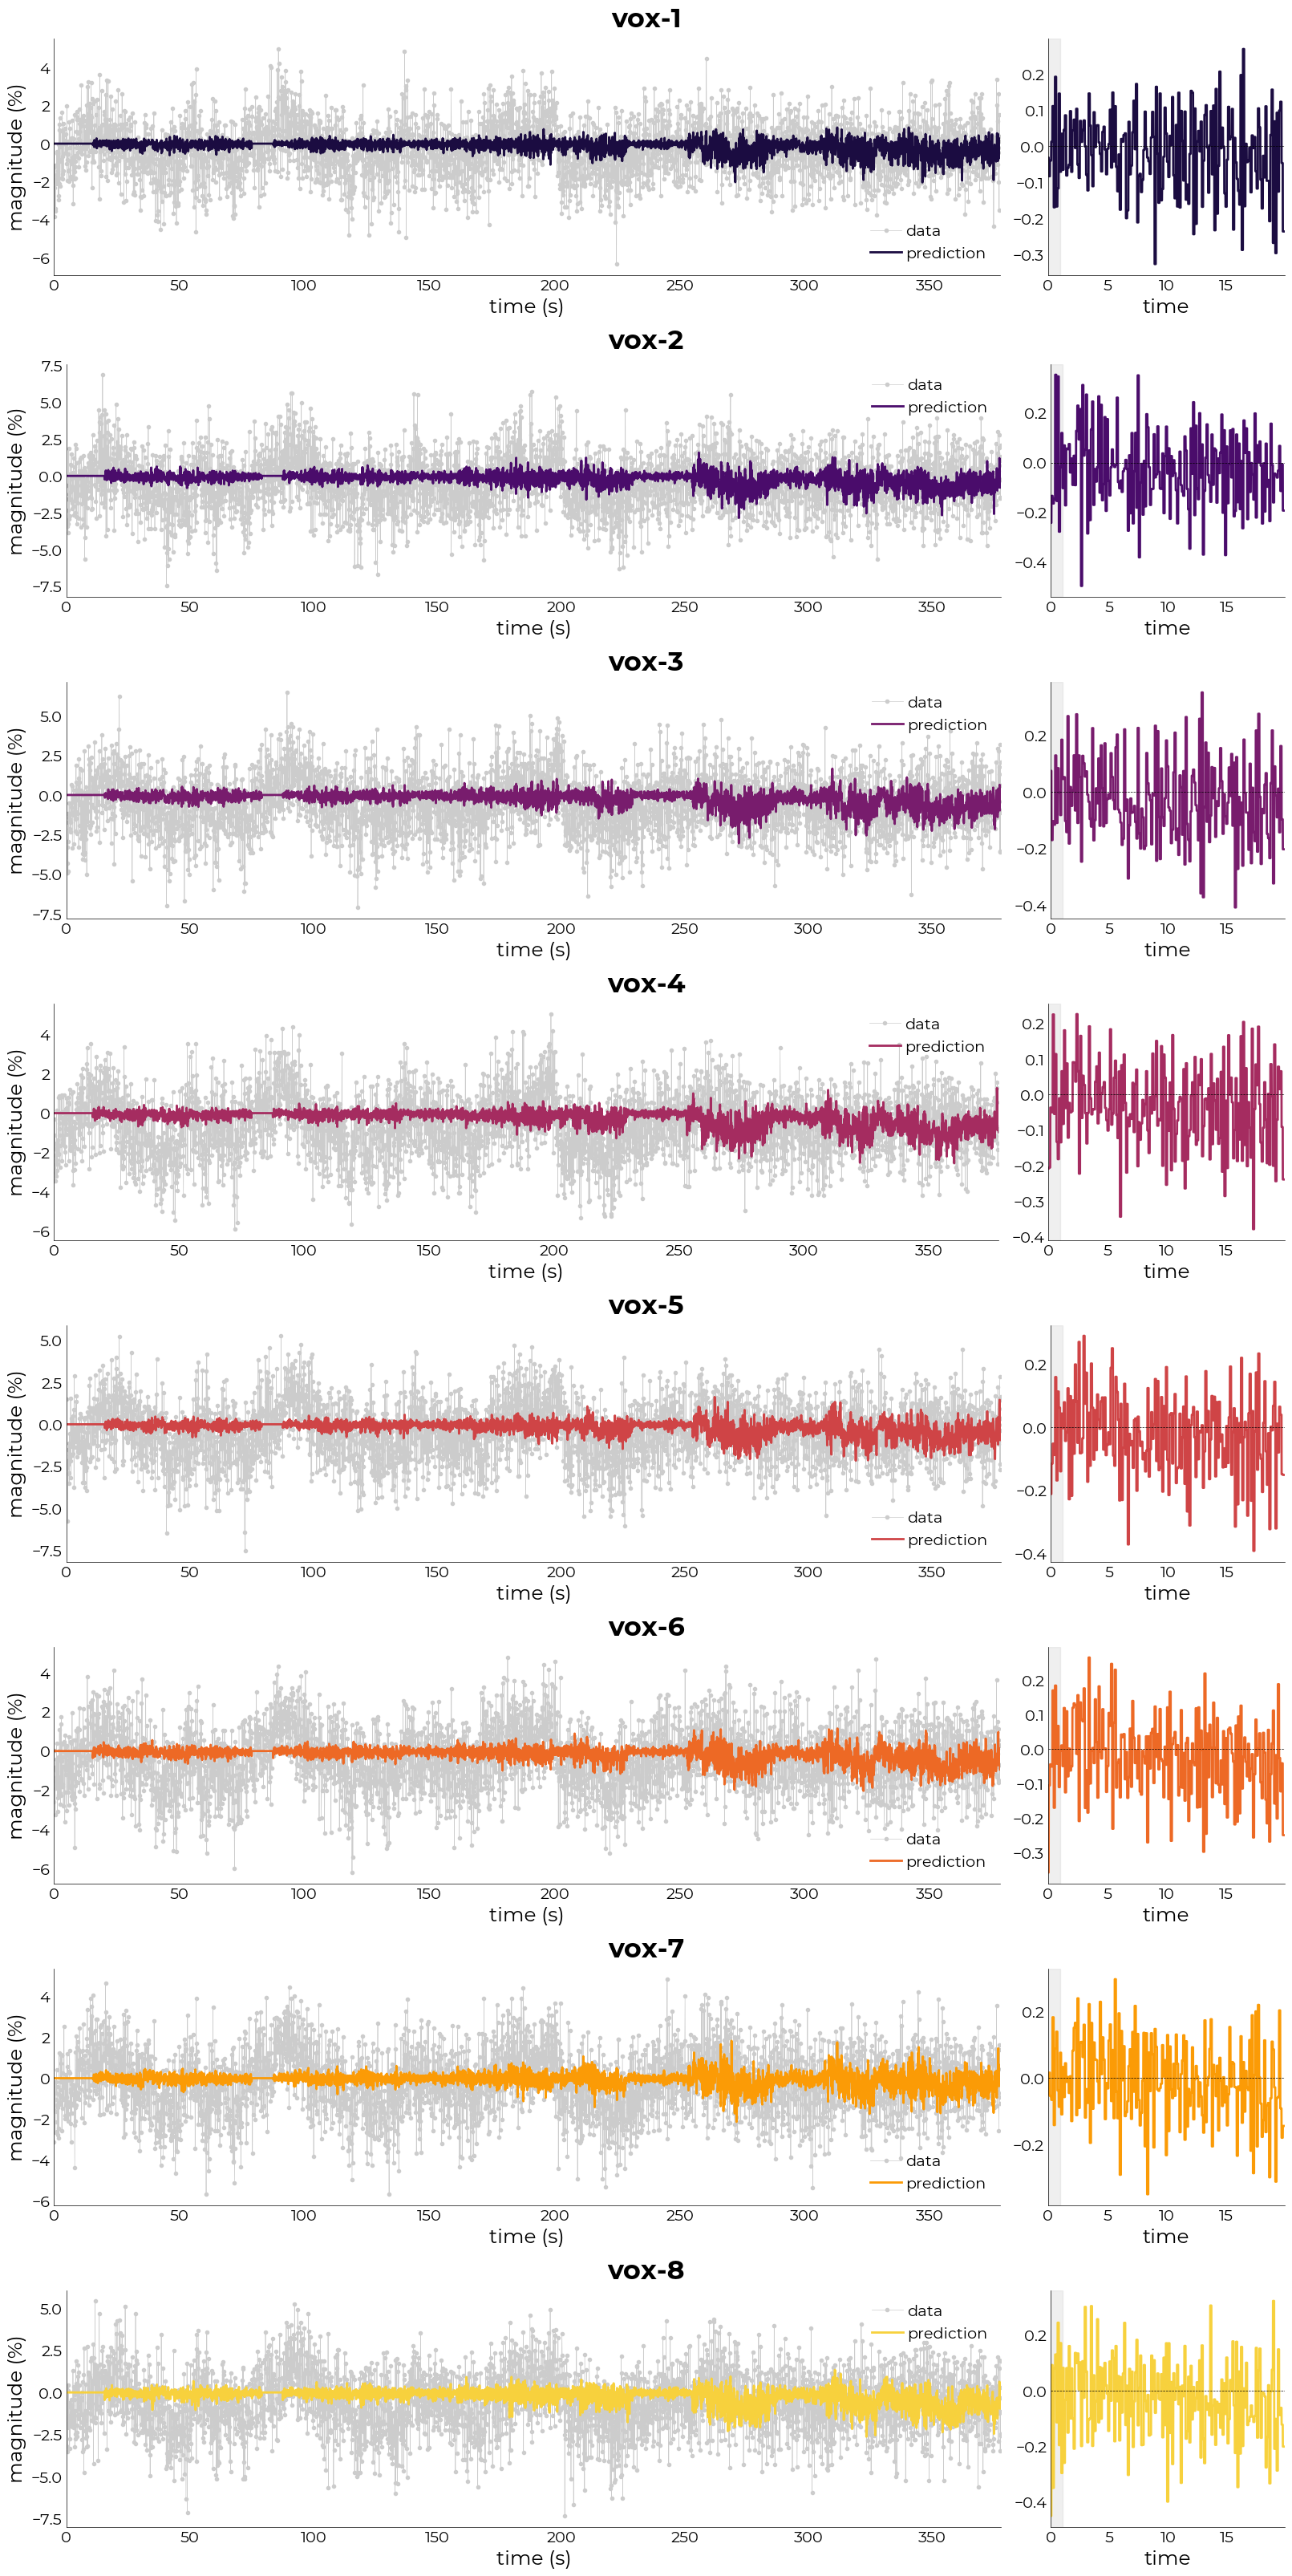

In [51]:
preproc.EventRegression.plot_model_fits(
    eye_fir,
)

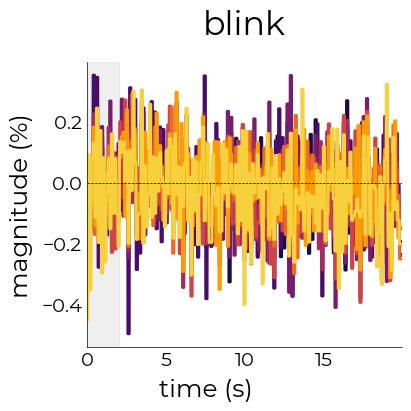

In [148]:
hr.viz.PlotDeconvProfiles(
    eye_fir,
    inset_par=None,
    # time_par="t"
)

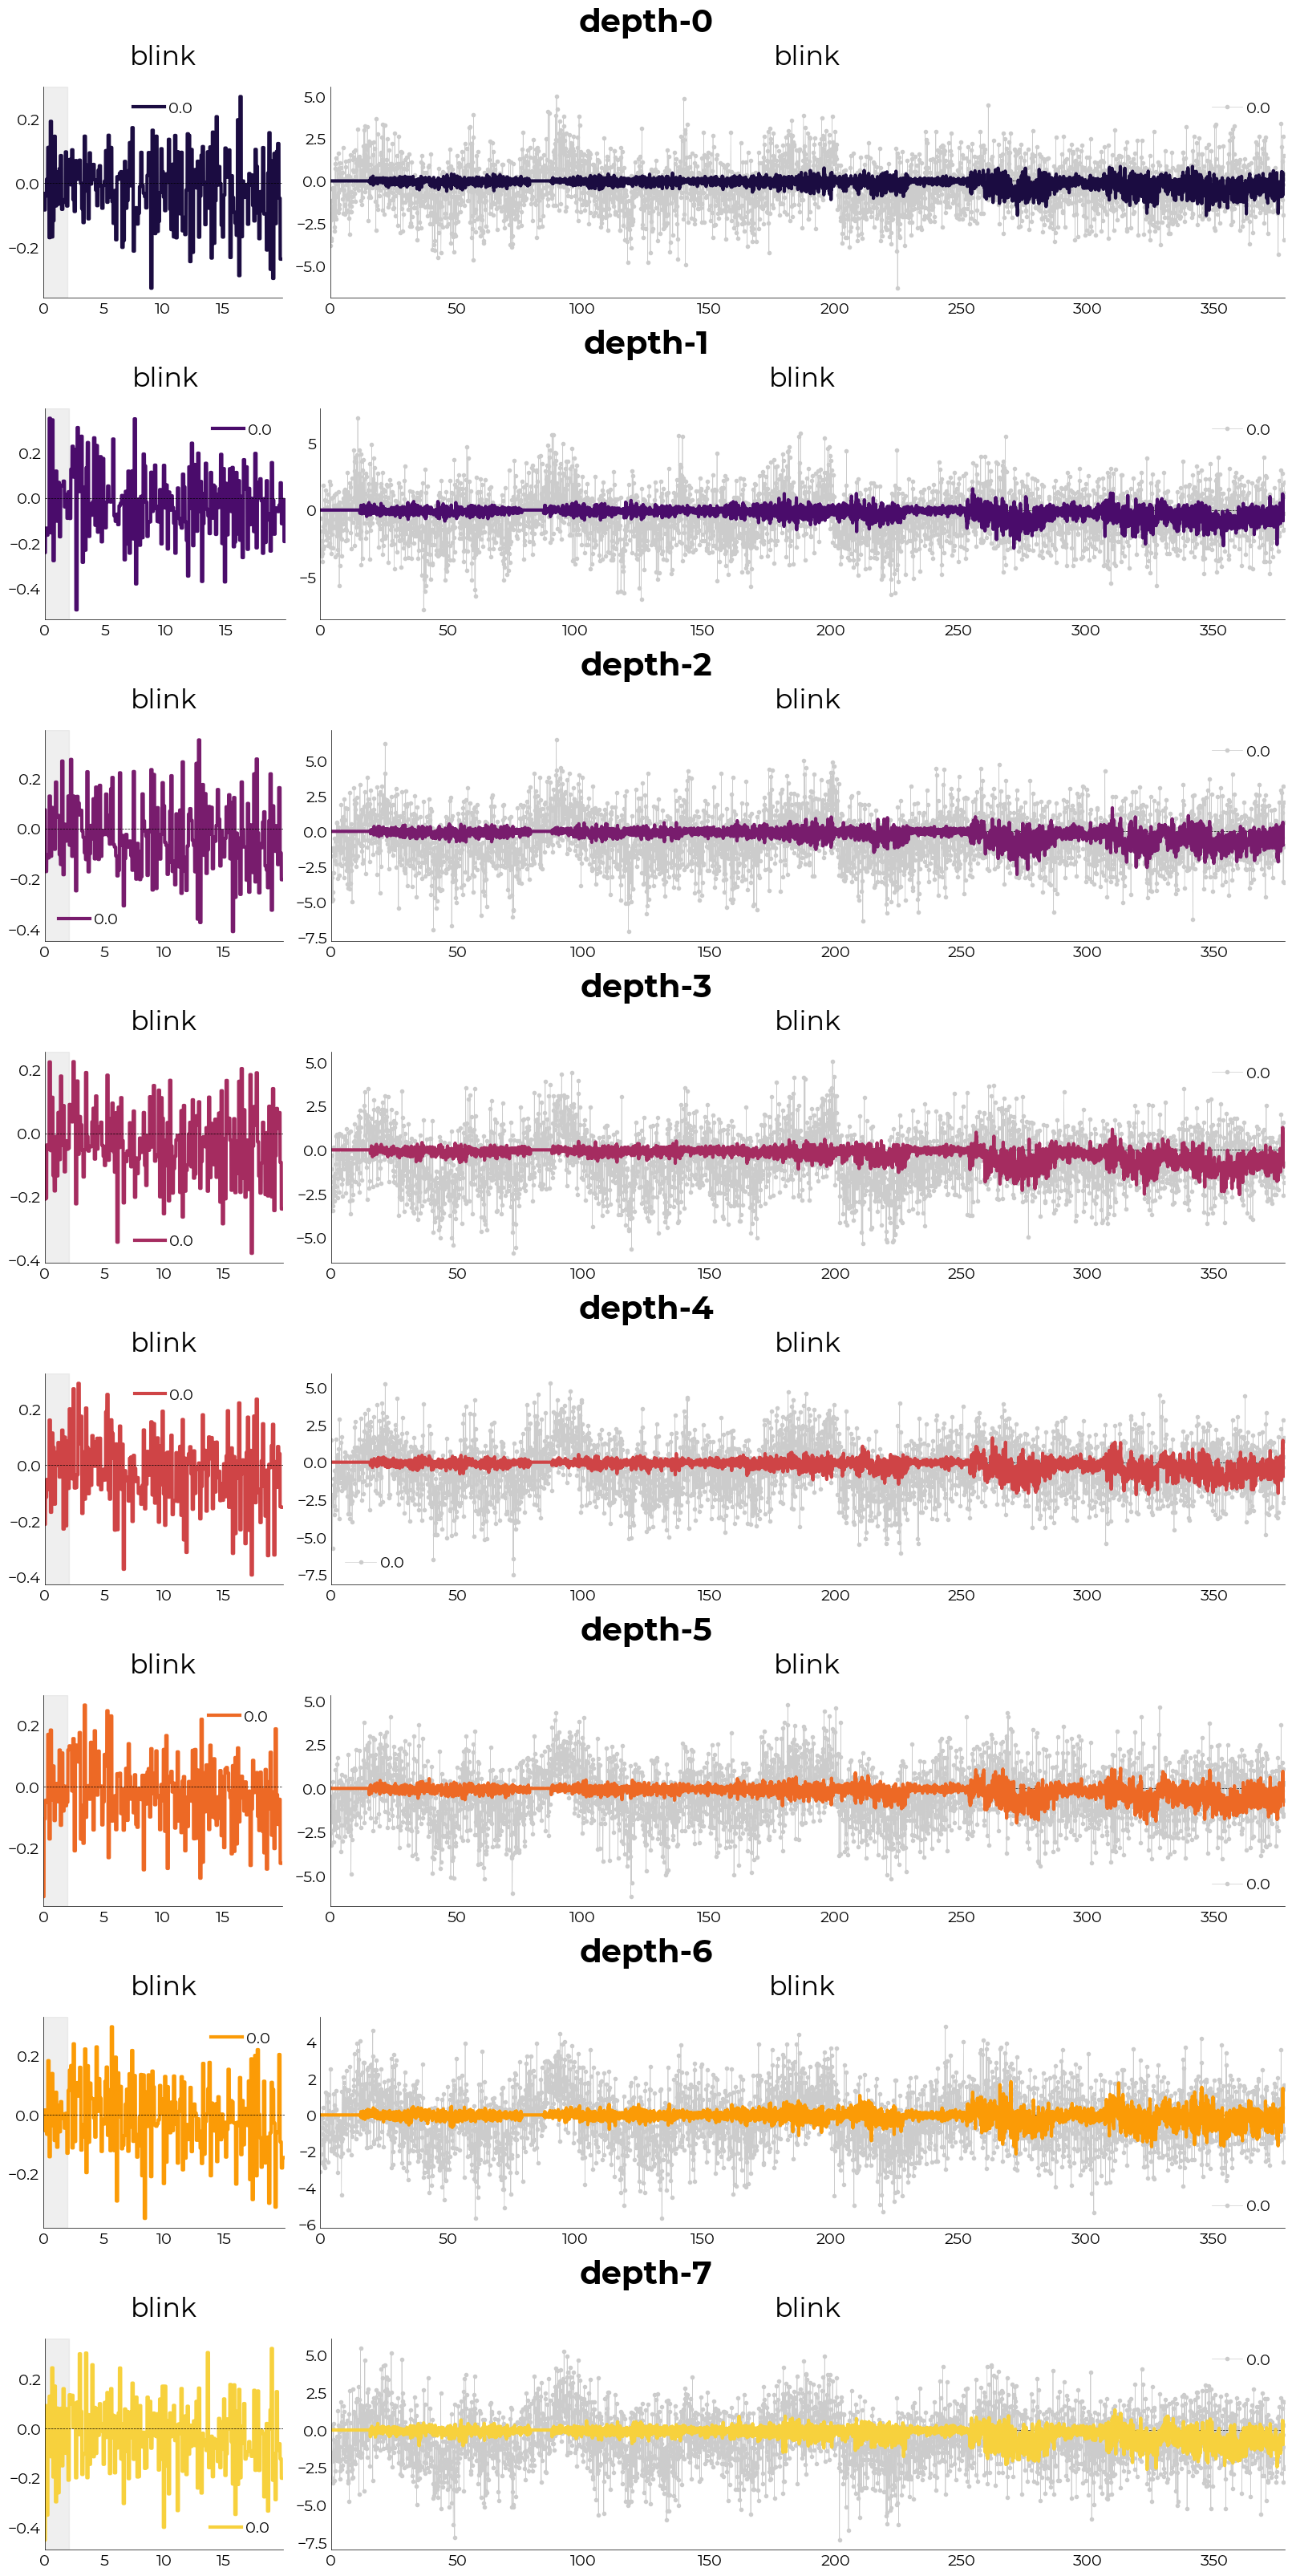

In [144]:
func_list = list(eye_fir.func.T.values)
fig = plt.figure(figsize=(16,eye_fir.func.shape[-1]*4), constrained_layout=True)
sf = fig.subfigures(nrows=eye_fir.func.shape[-1])

cms = sns.color_palette("inferno", eye_fir.func.shape[-1])
preds = list(eye_fir.sub_pred_full.T.values)
ddict = {}
for ix,tc in enumerate(func_list):

    axs = sf[ix].subplots(ncols=2, width_ratios=[0.2,0.8])

    ddict[f"depth_{ix}"] = {}
    for df_i,(tmp,tag,t_name,sh,col,mk,lw) in enumerate(zip(
        [eye_fir.tc_condition,eye_fir.func],
        ["profile","timecourse"],
        ["time","t"],
        [True,False],
        [[cms[ix]],"#cccccc"],
        [None,"."],
        [3,0.5])):


        df = pd.DataFrame(tmp.iloc[:,ix])
        idx = list(df.index.names)
        df.reset_index(inplace=True)
        df["event_type"] = "blink"
        idx.insert(1,"event_type")
        df.set_index(idx, inplace=True)

        ddict[f"depth_{ix}"][tag] = df.copy()
        hr.viz.PlotDeconvProfiles(
            df,
            inset_par=None,
            time_par=t_name,
            axs=axs[df_i],
            color=col,
            title=tag,
            onset_shade=sh,
            markers=mk,
            line_width=lw
        )
    
    pred_tc = preds[ix]
    ddict[f"depth_{ix}"]["pred"] = pred_tc
    pl = plotting.LazyPlot(
        pred_tc,
        xx=utils.get_unique_ids(eye_fir.func, id="t"),
        color=cms[ix],
        line_width=3,
        axs=axs[1]
    )

    sf[ix].suptitle(f"depth-{ix}", fontweight="bold", fontsize=pl.title_size*1.2)

    # pl = plotting.LazyPlot(
    #     tc, 
    # )

In [164]:
cleaned = preproc.RegressOut(
    eye_fir.func,
    eye_fir.sub_pred_full
)
cleaned.clean_df

vox 363   vox 364   vox 365   vox 366   vox 367  \
subject task run t                                                           
005     SRFa 4   0.000   -1.583248 -0.078777 -1.115862 -2.755631 -1.877493   
                 0.105   -0.835406 -0.074592 -0.561175 -0.408326  2.014904   
                 0.210   -3.462061 -2.854548 -4.323375 -1.106492 -2.118616   
                 0.315   -1.948396 -1.034742 -2.677754  0.407065 -1.933532   
                 0.420   -3.029489 -2.865793 -4.290944 -2.328821 -1.971753   
...                            ...       ...       ...       ...       ...   
                 377.475  0.466007 -0.854801 -0.425084 -1.897007  0.460121   
                 377.580 -3.107353 -0.991976 -2.764073 -1.360171 -2.507643   
                 377.685  1.745472  1.208585  2.200859 -0.146648  1.400877   
                 377.790  0.273653 -0.343772 -0.860705 -0.702229  0.114780   
                 377.895 -0.171866  2.139302  0.562419  0.022338  1.750815   

                           vox 368   vox 369   vox 370  
subject task run t                                      
005     SRFa 4   0.000   -2.105940 -2.902257 -2.531318  
                 0.105    0.516045  0.029225 -0.862798  
                 0.210   -0.365937 -1.387658  0.901417  
                 0.315   -1.062395  0.040407 -1.188149  
                 0.420   -1.435573 -1.935849 -1.435141  
...                            ...       ...       ...  
                 377.475 -1.193127 -2.708143 -2.850030  
                 377.580  0.380895  1.256556  0.598275  
                 377.685 -1.366337 -0.877535 -2.564466  
                 377.790  0.246471  1.080267  2.140144  
                 377.895  0.217754 -0.845659 -1.758305  

[3600 rows x 8 columns]

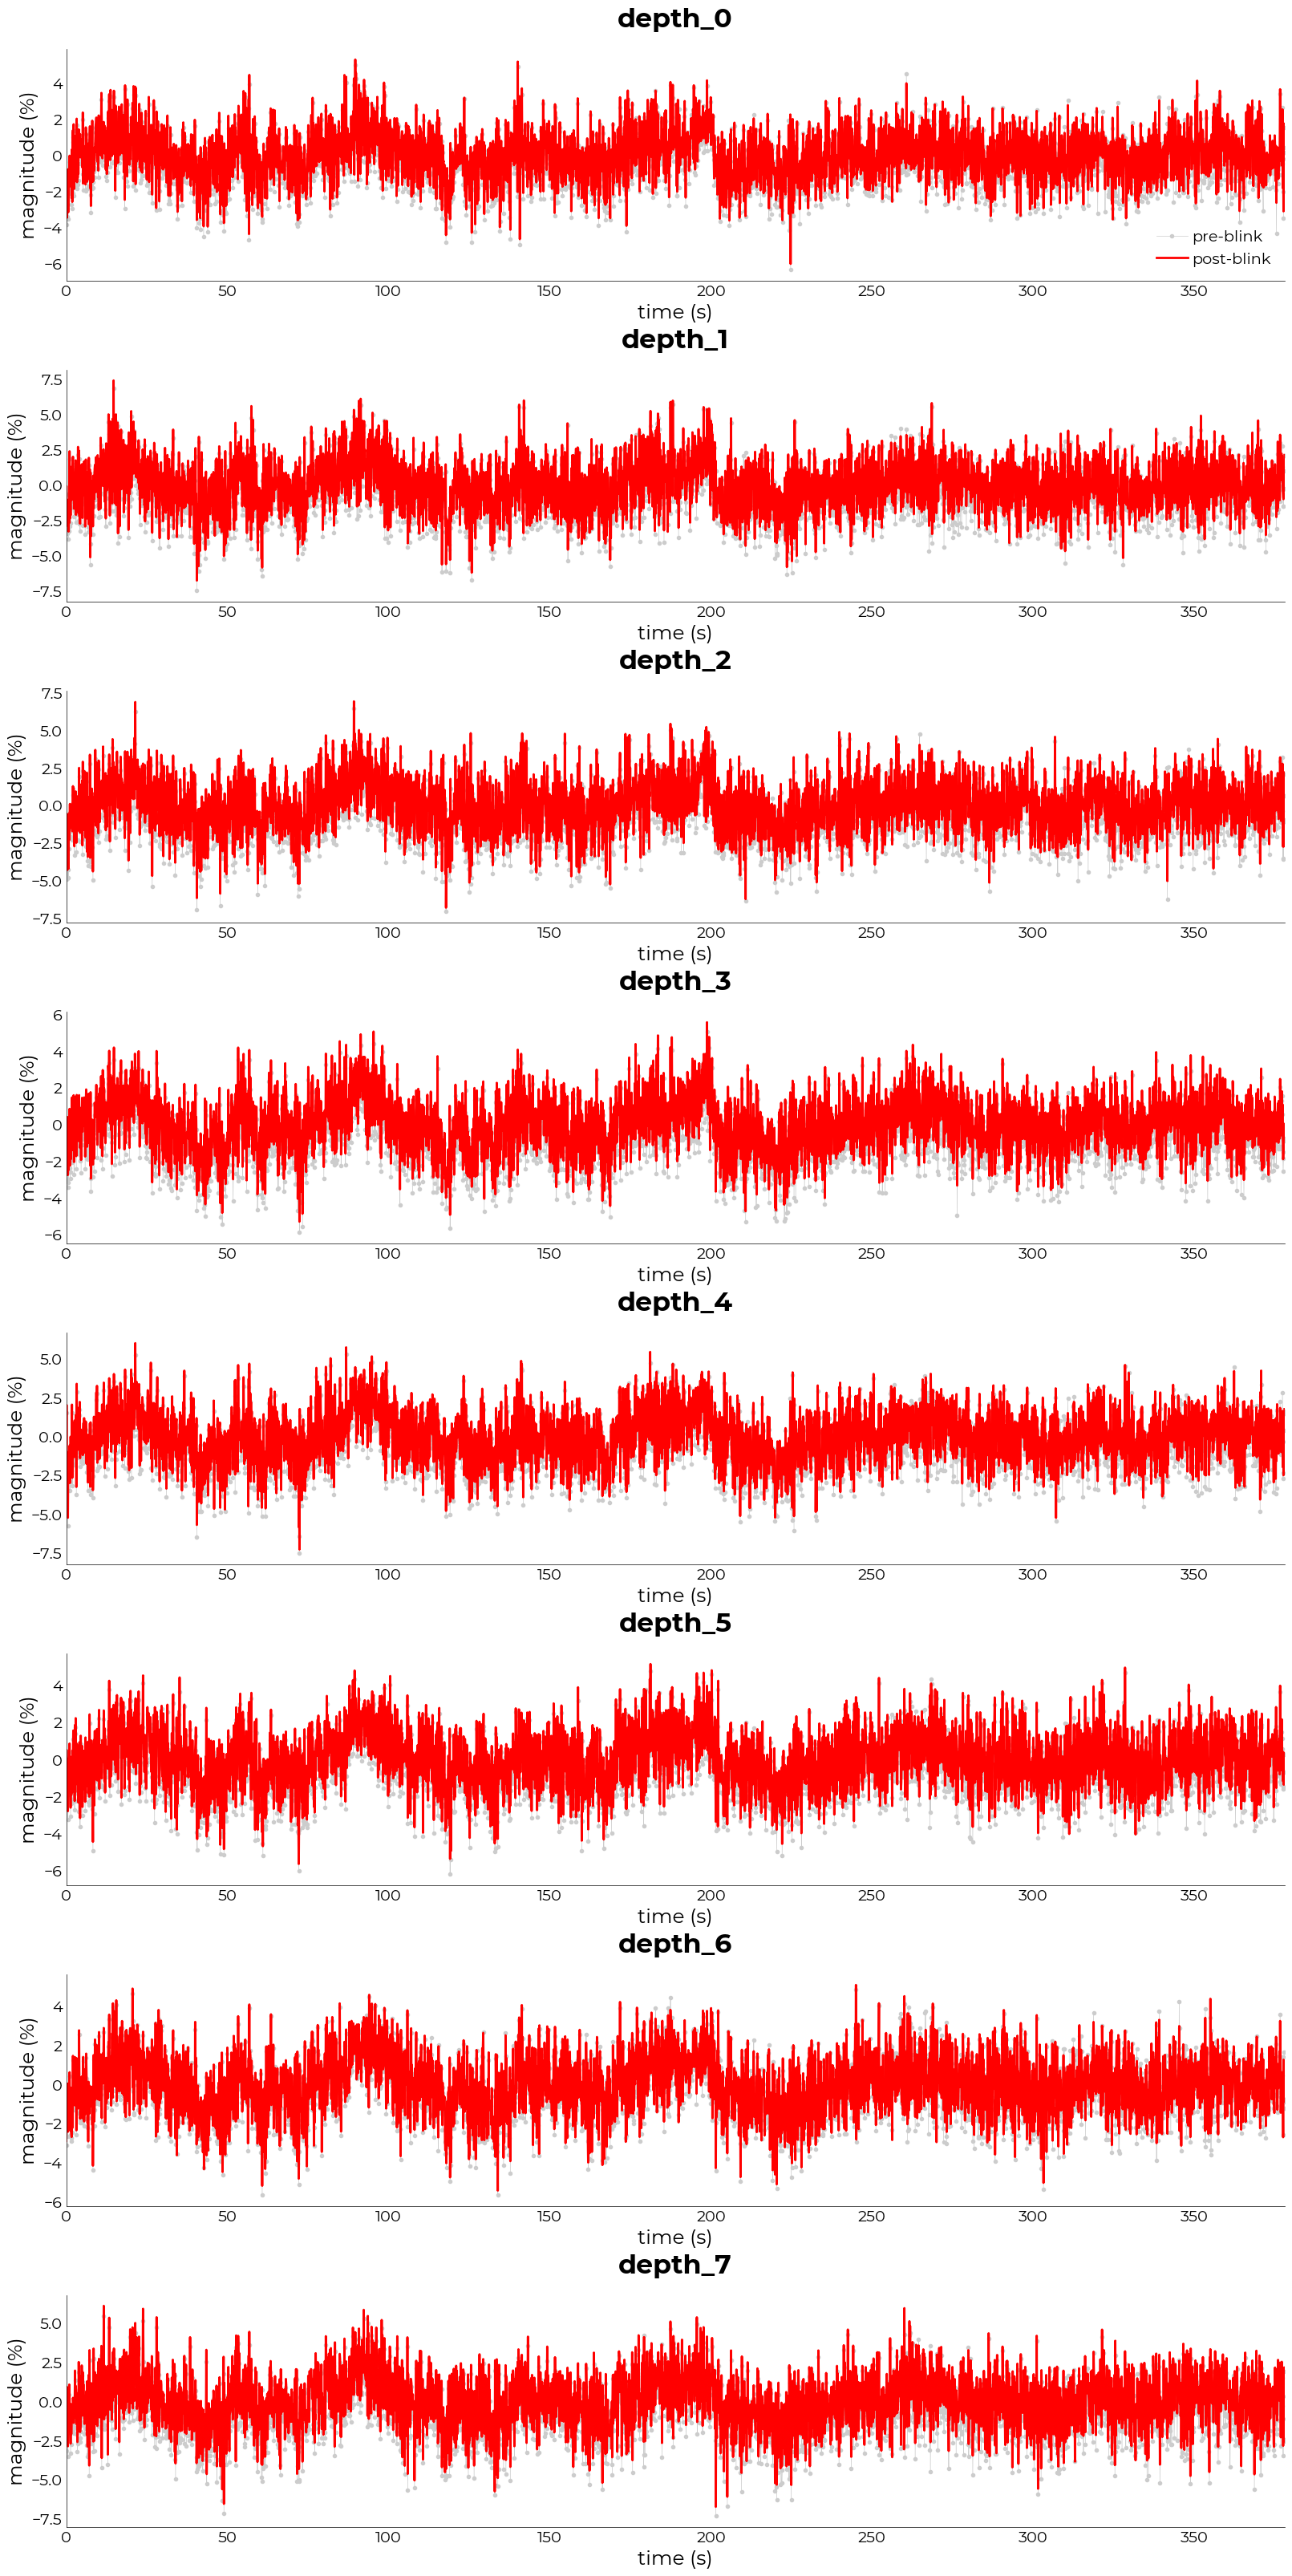

In [167]:
fig,axs = plt.subplots(nrows=len(ddict), figsize=(16,len(ddict)*4), constrained_layout=True)

# regress out FIR blink prediction
cleaned = preproc.RegressOut(
    eye_fir.func,
    eye_fir.sub_pred_full
)

for ix,(key,val) in enumerate(ddict.items()):
    tc_pre = eye_fir.func.iloc[:,ix].values
    tc_post = cleaned.clean_df.iloc[:,ix].values
    
    if ix == 0:
        lbl = ["pre-blink","post-blink"]
    else:
        lbl = None
        
    plotting.LazyPlot(
        [tc_pre,tc_post],
        xx=utils.get_unique_ids(eye_fir.func, id="t"),
        title={
            "title": key,
            "fontweight": "bold"
        },
        axs=axs[ix],
        markers=[".",None],
        line_width=[0.5,2],
        labels=lbl,
        color=["#cccccc","r"],
        y_label="magnitude (%)",
        x_label="time (s)"
    )

In [47]:
models = {}

for key,val in objs.items():

    # parse into single dataframe
    rib_df = val["obj"].dict_ribbon["sub-005"]
    rib_on = val["obj"].df_onsets
    ff = hr.data.make_single_df(rib_df)
    oo = hr.data.make_single_df(utils.select_from_df(rib_on, expression=f"subject = 005"), idx=["subject","run","event_type"])
    
    # fit
    can_fit = fitting.NideconvFitter(
        ff,
        oo,
        basis_sets='canonical_hrf_with_time_derivative_dispersion',
        # basis_sets="fourier",
        # n_regressors=4,
        TR=0.105,
        interval=[-2,26],
        verbose=True,
        conf_intercept=True
    )

    can_fit.timecourses_condition()

    models[key] = can_fit

Selected 'canonical_hrf_with_time_derivative_dispersion'-basis sets (with 3 regressors)
Adding event 'act' to model
Adding event 'suppr_1' to model
Adding event 'suppr_2' to model
Fitting with 'ols' minimization
Done
Selected 'canonical_hrf_with_time_derivative_dispersion'-basis sets (with 3 regressors)
Adding event 'act' to model
Adding event 'suppr_long' to model
Adding event 'suppr_short' to model
Fitting with 'ols' minimization
Done


In [48]:
models

{'orig': <linescanning.fitting.NideconvFitter at 0x7fcbfcaba040>,
 'long': <linescanning.fitting.NideconvFitter at 0x7fcbfd403310>}

In [50]:
import seaborn as sns

ev_names = ["center","near","far"]
ev_names2 = ["center","far (2s)","far (4s)"]
subID = "sub-005"
for ix,(key,use_model) in enumerate(models.items()):
    
    evs = [ev_names,ev_names2][ix]
    runIDs = utils.get_unique_ids(use_model.func, id="run")
    fig,axs = plt.subplots(nrows=len(runIDs), figsize=(14,4*len(runIDs)), constrained_layout=True)
    for ix,run in enumerate(runIDs):
        d_ev = utils.select_from_df(use_model.func, expression=f"run = {run}").mean(axis=1).values

        tcs = [d_ev]
        labels = ["data"]
        for ev_ix,ev in enumerate(use_model.cond):

            p_ev = utils.select_from_df(use_model.ev_predictions, expression=(f"run = {run}","&",f"event_type = {ev}")).mean(axis=1).values
            tcs.append(p_ev)
            labels += [evs[ev_ix]]
        
        if len(runIDs)<2:
            ax = axs
        else:
            ax = axs[ix]

        pl = plotting.LazyPlot(
            tcs,
            line_width=[0.5,3,3,3],
            color=["#cccccc"]+subj_obj.get_colors(),
            x_label="volumes",
            y_label="magnitude",
            add_hline=0,
            axs=ax,
            labels=labels,
            # y_lim=[-2.5,2.5],
            title=f"run-{run}"
        )

    fig.suptitle(subID, fontweight="bold", fontsize=pl.title_size*1.3)
    hr.viz._save_figure(
        fig, 
        subject=subID, 
        fname=f"sub-{subID.split('-')[-1]}_ses-{key}_desc-timecourses_filt"
    )

    plt.close()

Writing '/data1/projects/MicroFunc/Jurjen/programs/project_repos/holeresponse/images/sub-005/sub-005_ses-orig_desc-timecourses_filt.pdf'
Writing '/data1/projects/MicroFunc/Jurjen/programs/project_repos/holeresponse/images/sub-005/sub-005_ses-orig_desc-timecourses_filt.png'
Writing '/data1/projects/MicroFunc/Jurjen/programs/project_repos/holeresponse/images/sub-005/sub-005_ses-long_desc-timecourses_filt.pdf'
Writing '/data1/projects/MicroFunc/Jurjen/programs/project_repos/holeresponse/images/sub-005/sub-005_ses-long_desc-timecourses_filt.png'
